In [5]:
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as shpg
from scipy.interpolate import griddata
import matplotlib.pylab as pylab
from eod import msg as msg
import cartopy.crs as ccrs
import cartopy.feature as cfeature
pylab.rcParams['figure.figsize'] = 20., 12.
%matplotlib inline
import pyproj
import cleo
import salem
import pickle as pkl

In [6]:
HOD=range(24)   # hours of day
CFAC=-781648343
LFAC=-781648343
COFF=1856
LOFF=1856
YRANGE=range(2004,2014)

tpath= "/users/global/cornkle/data/OBS/TRMM/trmm_swaths_WA/"
tf=msg.extract_TRMMfile(tpath, hod=HOD, yrange=YRANGE, mtresh=1)
tf.keys()
print(len(tf['fpath']))

1064


In [7]:
dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=0)

In [8]:
tnb=np.array(range(len(tf['fpath'])))
maxs=[]
for tp in tnb:
    dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=tp)
    td=dtrmm['pcp'].mean().max()
    maxs.append(td)
sort_max, sort_nbs = zip(*sorted(zip(maxs, tnb), reverse=True))

In [9]:
print(sort_max[0:10])
print(sort_nbs[0:10])

(1.4574619424316959, 1.2604372566636717, 0.94629474740715935, 0.78822898650985818, 0.75571597933779322, 0.72896770358628882, 0.71934199688844147, 0.70978014394163458, 0.7065073397780165, 0.70113297988234424)
(334, 490, 845, 437, 730, 696, 841, 79, 992, 288)


In [14]:
top5=sort_nbs[0:5]
print(top5)

(334, 490, 845, 437, 730)


In [222]:
NB=top5[4]
mi=tf['tmins'][NB]
dmsg, dtrmm=msg.quickreadTrmmMSG(tf, nb=NB)
mlat=dmsg['lats']
mlon=dmsg['lons']
md=dmsg['t']
tlat=dtrmm['lats']
tlon=dtrmm['lons']
td=dtrmm['pcp']
print(mi)
mlon.flatten()

32


array([-16.78334045, -16.75442505, -16.72542572, ...,  32.65229416,
        32.69068527,  32.72912598], dtype=float32)

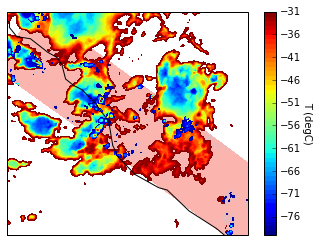

In [233]:
dy1=50
dy2=350
dx1=0
dx2=280
tdy1=80
tdy2=400

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.contourf(tlon[tdy1:tdy2, :], tlat[tdy1:tdy2, :], td[tdy1:tdy2, :],levels=np.arange(0,100, 0.5), transform=ccrs.PlateCarree(), cmap='Pastel1')
plt.contourf(mlon[dy1:dy2, dx1:dx2], mlat[dy1:dy2, dx1:dx2], md[dy1:dy2, dx1:dx2], levels=np.arange(-80,-30,1), transform=ccrs.PlateCarree())

cbar=plt.colorbar()
cbar.set_label('T (degC)', rotation=270, labelpad=+11)
plt.contourf(tlon[tdy1:tdy2, :], tlat[tdy1:tdy2, :], td[tdy1:tdy2, :],levels=np.arange(5,70, 0.5), transform=ccrs.PlateCarree())

#ax.coastlines()
#cbar=plt.colorbar()
#cbar.set_label('PCP (mm h-1)', rotation=270, labelpad=+11)
#plt.savefig('/users/global/cornkle/'+str(NB)+'_msgtd0_p_'+str(mi)+'.pdf')

In [234]:
mlat=dmsg['lats'][dy1:dy2, dx1:dx2]
mlon=dmsg['lons'][dy1:dy2, dx1:dx2]

print(mlat.flatten().max(), mlon.flatten().max(), mlat.flatten().min(), mlon.flatten().min())

mx, my = pyproj.transform(salem.wgs84, proj, mlon, mlat)
tx, ty = pyproj.transform(salem.wgs84, proj, tlon, tlat)
        
ax=mx.flatten().tolist()
ay=my.flatten().tolist()
        
# take the min and max
xmax, xmin = max(ax), min(ax)
ymax, ymin = max(ay), min(ay) 

print(xmax, xmin, ymax, ymin)
        
#Count the number of pixels
dx = 5000
nx, r = divmod(xmax - xmin, dx)
ny, r = divmod(ymax - ymin, dx)

13.7038 -8.94245 5.28958 -17.3317
-995468.7202186929 -1929351.277447705 1530137.8572235834 585734.8484368948


In [235]:
 # Here one could add + 1 to be sure that the last pixel is always included
grid = salem.Grid(nxny=(nx, ny), dxdy=(dx, dx), ll_corner=(xmin, ymin), proj=proj)        
xi, yi = grid.ij_coordinates
lon, lat = grid.ll_coordinates

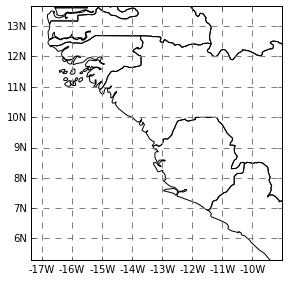

In [236]:
cm = cleo.Map(grid)
cm.visualize()

In [237]:
# Transform lons, lats to grid
xm, ym = grid.transform(mlon.flatten(), mlat.flatten(), crs=salem.wgs84)
xt, yt = grid.transform(tlon.flatten(), tlat.flatten(), crs=salem.wgs84)

In [238]:
# Convert for griddata input 
mpoints = np.array((ym, xm)).T
tpoints = np.array((yt, xt)).T
inter = np.array((np.ravel(yi), np.ravel(xi))).T

In [239]:
# Interpolate using delaunay triangularization 
outm = griddata(mpoints, md[dy1:dy2, dx1:dx2].flatten(), inter, method='linear')
outm = outm.reshape((grid.ny, grid.nx))

In [240]:
#outm[np.isnan(outm)]=30

In [241]:
# Interpolate using delaunay triangularization 
outt = griddata(tpoints, td.flatten(), inter, method='linear')
outt = outt.reshape((grid.ny, grid.nx))

0

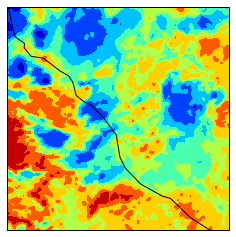

In [261]:
dx=10
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
#plt.contourf(lon, lat, outt,levels=np.arange(0,100, 0.5), transform=ccrs.PlateCarree(), cmap='Pastel1')
plt.contourf(lon[dx:-dx, dx:-dx], lat[dx:-dx, dx:-dx], outm[dx:-dx, dx:-dx], transform=ccrs.PlateCarree())


In [106]:
outt

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ..., 
       [ 1.97047624,  1.00701656,  1.13362654, ...,         nan,
                nan,         nan],
       [ 0.95598434,  0.24277086,  0.        , ...,         nan,
                nan,         nan],
       [ 1.47029678,  0.18983197,  0.        , ...,         nan,
                nan,         nan]])

/users/global/cornkle/data/pythonWorkspace/proj_CEH/cleo/graphics.py:176: RuntimeWarning: Maximum data out of bounds.
  warnings.warn('Maximum data out of bounds.', RuntimeWarning)


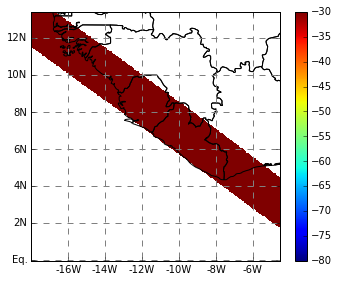

ValueError: Dimensions of data do not match the map.

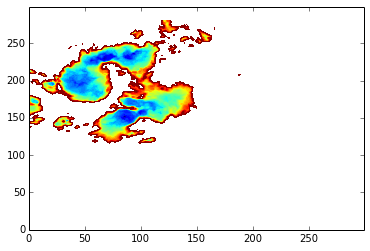

In [139]:
plt.contourf(yi.T, xi.T, outm,levels=np.arange(-80,-30,1))
#plt.contourf(yi.T, xi.T, outt, levels=np.arange(5,70, 0.5))
plt.savefig('/users/global/cornkle/'+str(NB)+'_msgtest_'+str(mi)+'.pdf')

In [5]:
dic = pkl.load( open ('/users/global/cornkle/mt_wavelet_test.p', 'rb'))

UnicodeDecodeError: 'ascii' codec can't decode byte 0xcc in position 0: ordinal not in range(128)